# PEBRASSOS

## Detección de categorias a partir de imagenes

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import EfficientNetB3

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
SEED = 99
PATH = "images/"
IMG_WIDTH = 300
IMG_HEIGHT = 300
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 8

In [5]:
# Necesitaremos montar su disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, puedes consultar: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/10_MachineLearning_JS/Cursos/Curso_WebScraping/web-scraping-master/NIVEL 3

/content/drive/MyDrive/10_MachineLearning_JS/Cursos/Curso_WebScraping/web-scraping-master/NIVEL 3


In [7]:
%ls images/

'Agaricus campestris'/  'Cantharellus Cibarius'/      'lactarius deliciosus'/
'Amanita Caesaera'/     'cratarellus comucopioides'/  'Lactarius sanguifluus'/
'Boletus Edulis'/       'Hygrophorus latitabundus'/


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.15,
    subset="training",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode = "categorical"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode = "categorical"
)

Found 870 files belonging to 8 classes.
Using 740 files for training.
Found 870 files belonging to 8 classes.
Using 130 files for validation.


In [9]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomZoom(.5, .2),
        layers.experimental.preprocessing.RandomCrop(150, 150),

    ]
)

In [10]:
train_ds_visu = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.prefetch(buffer_size=BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=BATCH_SIZE)

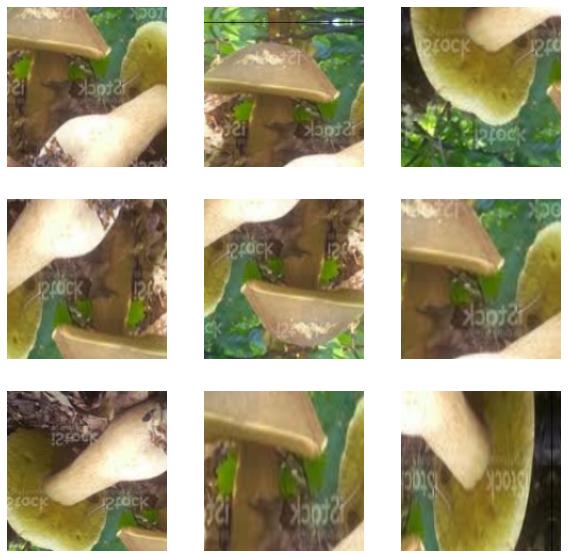

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

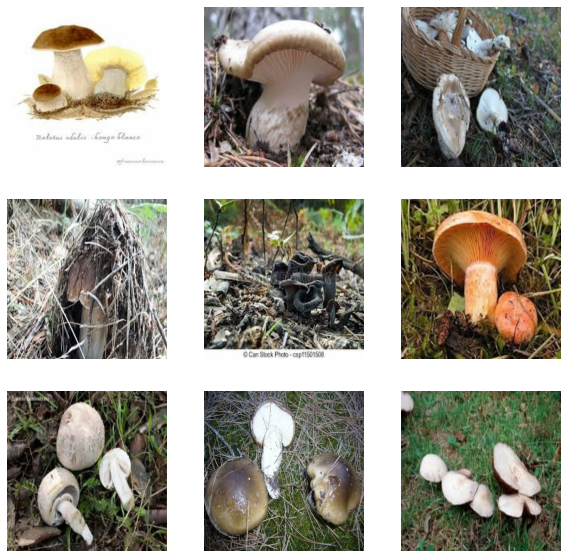

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
with tf.device('/device:GPU:0'):
  def build_model(num_classes):
      inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
      model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

      # Freeze the pretrained weights
      model.trainable = False

      # Rebuild top
      x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
      x = tf.keras.layers.BatchNormalization()(x)

      top_dropout_rate = 0.2
      x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
      outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

      # Compile
      model = tf.keras.Model(inputs, outputs, name="EfficientNet")
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
      model.compile(
          optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
      )
      return model


In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

model = build_model(NUM_CLASSES)
unfreeze_model(model)

In [20]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [ ]:
callbacks = [
  tf.keras.callbacks.ModelCheckpoint('modelEFNB3-epoch-{epoch:03d}-accuracy-{accuracy:03f}-val-acc-{val_accuracy:03f}.h5', 
                                     verbose=1, monitor='val_loss',
                                     save_best_only=True, mode='auto'),
  # tf.keras.callbacks.EarlyStopping(   monitor='val_loss',
  #                                     min_delta=0,
  #                                     patience=4,
  #                                     verbose=1,
  #                                     mode='auto',
  #                                     baseline=None,
  #                                     restore_best_weights=True
# )
]

In [22]:
history = model.fit(
  train_ds,
  batch_size = BATCH_SIZE,
  callbacks=callbacks,
  validation_data = val_ds, 
  epochs = EPOCHS)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 1.9292 - accuracy: 0.3541
Epoch 00001: val_loss improved from inf to 1.52461, saving model to modelEFNB3-epoch-001-accuracy-0.354054-val-acc-0.600000.h5
47/47 [==============================] - 7s 145ms/step - loss: 1.9292 - accuracy: 0.3541 - val_loss: 1.5246 - val_accuracy: 0.6000
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.7324
Epoch 00002: val_loss improved from 1.52461 to 1.15660, saving model to modelEFNB3-epoch-002-accuracy-0.732432-val-acc-0.823077.h5
47/47 [==============================] - 6s 118ms/step - loss: 0.8128 - accuracy: 0.7324 - val_loss: 1.1566 - val_accuracy: 0.8231
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.5121 - accuracy: 0.8338
Epoch 00003: val_loss improved from 1.15660 to 0.86413, saving model to modelEFNB3-epoch-003-accuracy-0.833784-val-acc-0.884615.h5
47/47 [==============================] - 6s 123ms/step - loss: 0.51

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


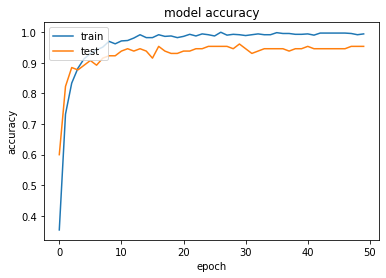

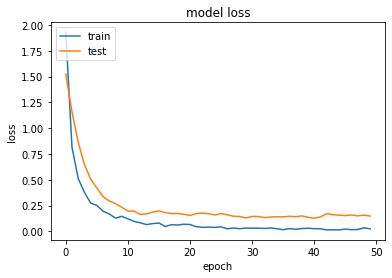

In [23]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
TEST_IMAGE = "name.jpg"

In [31]:
img = tf.keras.preprocessing.image.load_img(
    TEST_IMAGE, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

print(score)

AttributeError: ignored